# Node Degree

## Load dependencies

In [97]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker as mticker
from lib.dictionaries import read_dictionary_one_to_set
import re
import dataframe_image as dfi
from statistics import median, mean
import visualization.visualize_single_network as v

import config
from config import LEVELS, INTERACTOMES_PATH, METHODS, DATA_REACTOME_PATH, PATHWAY_GRAPHS_PATH, genes, proteins, proteoforms, COLOR_GENES_FILL, COLOR_PROTEOFORMS_FILL
from lib.networks import get_interactomes, get_combinations, get_combinations_with_pathways
from lib.networks import get_multiindex, get_sizes, get_json_filename, create_pathway_interaction_network, read_graph, \
    get_pathways_with_multiple_proteoforms, get_increase_percentage, create_pathway_interaction_networks
from lib.graph_database_access import get_pathways
from queries import QUERY_GET_PATHWAYS_BY_PROTEIN
from lib.graph_database_access import get_query_result

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

config.set_root_wd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Initial working directory: C:\git\ProteoformNetworks\src\Python
New working directory: c:\git\ProteoformNetworks


# Degree by Interactomes

## Load interactomes

In [85]:
index = get_multiindex()
interactomes_no_sm, interactomes_with_sm, interactomes_with_unique_sm = get_interactomes(DATA_REACTOME_PATH, INTERACTOMES_PATH)
interactomes = [interactomes_no_sm[genes], interactomes_no_sm[proteoforms], interactomes_with_sm[genes], interactomes_with_sm[proteoforms], interactomes_with_unique_sm[genes], interactomes_with_unique_sm[proteoforms]]

Reading participants of all reactions for level genes...
Reading participants of all reactions for level proteoforms...
Reading participants of all reactions for level sm...
Reading components of all complexes for level genes...
Reading components of all complexes for level proteoforms...
Reading components of all complexes for level sm...
Reading interaction network for  at genes level, method no_sm...
Reading interaction network for  at proteoforms level, method no_sm...
Reading interaction network for  at genes level, method with_sm...
Reading interaction network for  at proteoforms level, method with_sm...
Reading interaction network for  at genes level, method with_unique_sm...
Reading interaction network for  at proteoforms level, method with_unique_sm...


## Degree of all proteoforms and its genes

In [86]:
map_proteins_to_genes = read_dictionary_one_to_set(INTERACTOMES_PATH, "mapping_proteins_to_genes.tsv", col_indices=(0, 1))
map_proteins_to_genes
proteoform_degrees = [(node, val) for (node, val) in interactomes_no_sm[proteoforms].degree()]
proteoform_degrees

df_degrees_genes_vs_all_proteoforms = pd.DataFrame(proteoform_degrees, columns=["Proteoform", "Proteoform Degree"])
df_degrees_genes_vs_all_proteoforms["Gene"] = df_degrees_genes_vs_all_proteoforms['Proteoform'].apply(lambda proteoform: list(map_proteins_to_genes[proteoform[:re.search("[;-]", proteoform).start()]])[0])
df_degrees_genes_vs_all_proteoforms["Gene Degree"] = df_degrees_genes_vs_all_proteoforms["Gene"].apply(lambda gene: interactomes_no_sm[genes].degree[gene])
df_degrees_genes_vs_all_proteoforms["Annotations"] = df_degrees_genes_vs_all_proteoforms['Proteoform'].apply(lambda proteoform: any((c in {':', '-'}) for c in str(proteoform)))
df_degrees_genes_vs_all_proteoforms

,Proteoform,Proteoform Degree,Gene,Gene Degree,Annotations
0,P08887-2;,25,IL6R,15,True
1,P05231;,264,IL6,149,False
2,O60674;,166,JAK2,175,False
3,P23458;,143,JAK1,154,False
4,P29597;,86,TYK2,93,False
...,...,...,...,...,...
14241,Q9UN19;00048:139,2,DAPP1,1,True
14242,P40259;,68,CD79B,80,False
14243,P11912;,68,CD79A,80,False
14244,"P06241;00068:2,00115:3,00115:6",67,FYN,297,True


## Plot degree distribution in the interactomes

In [87]:
degree_sequences = []
for interactome in interactomes:            
    accessioned_nodes = [node for node, data in interactome.nodes(data=True) if not data['type'].startswith("Simple")]
    sequence = sorted([d for n, d in interactome.degree(accessioned_nodes)], reverse=True)
    degree_sequences.append(sequence)

degree_sequences = pd.Series(degree_sequences, index=index)
degree_sequences

Small Molecules           Entity Level
Not Included              genes           [1243, 1220, 1059, 1059, 586, 579, 540, 530, 5...
                          proteoforms     [1474, 1449, 1284, 1284, 627, 619, 606, 604, 6...
Included                  genes           [1290, 1267, 1103, 1103, 765, 754, 645, 642, 6...
                          proteoforms     [1520, 1495, 1327, 1327, 780, 762, 747, 720, 7...
Reaction-Unique Included  genes           [2361, 2331, 1989, 1806, 1766, 1556, 1556, 153...
                          proteoforms     [2376, 2339, 2029, 1997, 1987, 1773, 1773, 153...
dtype: object

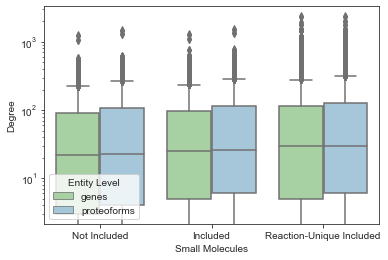

In [88]:
df_seq = pd.DataFrame({"Sequence": degree_sequences})
df_seq.reset_index(inplace=True)

lst_col = 'Sequence'

df_seq = pd.DataFrame({
    col: np.repeat(df_seq[col].values, df_seq[lst_col].str.len())
    for col in df_seq.columns.drop(lst_col)}
).assign(**{lst_col: np.concatenate(df_seq[lst_col].values)})[df_seq.columns]

df_seq = df_seq.rename(columns={'Sequence': 'Degree'})
df_seq
ax = sns.boxplot(x="Small Molecules", y="Degree", hue="Entity Level",
                 data=df_seq, palette=[COLOR_GENES_FILL, COLOR_PROTEOFORMS_FILL])
ax.set_yscale('log')
ax.figure.savefig('figures/degree_interactomes.png')

In [89]:
degrees_genes = degree_sequences["Included", "genes"]
degrees_proteoforms = degree_sequences["Included", "proteoforms"]
change = get_increase_percentage(len(degrees_genes), len(degrees_proteoforms))
print(f"the degree in the complete proteoform network is increased in average from {mean(degrees_genes)} to {mean(degrees_proteoforms)} connections ({change} %)")

the degree in the complete proteoform network is increased in average from 72.88073979591837 to 88.06310543310403 connections (22.95 %)


## Degree of proteoforms with annotations

In [90]:
proteoforms_no_annotations = [node for node in interactomes_no_sm['proteoforms'].nodes if not any((c in {':', '-'}) for c in str(node))]
proteoforms_with_annotations = [node for node in interactomes_no_sm['proteoforms'].nodes if any((c in {':', '-'}) for c in str(node))]

modified_proteoform_degrees = [(node, val) for (node, val) in interactomes_no_sm["proteoforms"].degree(proteoforms_with_annotations)]

df_degrees_genes_vs_proteoforms_with_annotations = pd.DataFrame(modified_proteoform_degrees, columns=["Proteoform", "Proteoform Degree"])
df_degrees_genes_vs_proteoforms_with_annotations["Gene"] = df_degrees_genes_vs_proteoforms_with_annotations['Proteoform'].apply(lambda proteoform: list(map_proteins_to_genes[proteoform[:re.search("[;-]", proteoform).start()]])[0])
df_degrees_genes_vs_proteoforms_with_annotations["Gene Degree"] = df_degrees_genes_vs_proteoforms_with_annotations["Gene"].apply(lambda gene: interactomes_no_sm[genes].degree[gene])
df_degrees_genes_vs_proteoforms_with_annotations["Annotations"] = df_degrees_genes_vs_proteoforms_with_annotations['Proteoform'].apply(lambda proteoform: any((c in {':', '-'}) for c in str(proteoform)))
dfi.export(df_degrees_genes_vs_proteoforms_with_annotations.set_index("Proteoform").sample(20), 'figures/df_degrees_genes_vs_modified_proteoforms.png')
df_degrees_genes_vs_proteoforms_with_annotations.sample(20)

,Proteoform,Proteoform Degree,Gene,Gene Degree,Annotations
1994,P04150-9;,85,NR3C1,84,True
3023,Q9MY60;01148:null,12,HLA-B,138,True
1614,Q71DI3;00078:3,19,H3C15,343,True
2482,O60879-3;,8,DIAPH2,134,True
1337,P00367;00064:null,5,GLUD1,6,True
2294,P15941;00163:null,83,MUC1,66,True
228,"Q9Y5J6;00034:28,00034:32",9,TIMM10B,9,True
1494,Q86XL3;00064:302,1,ANKLE2,21,True
3004,P62253;00211:90,44,UBE2G1,258,True
1243,"Q12968;00046:168,00046:169,00046:171,00046:172...",9,NFATC3,8,True


In [91]:
degrees_proteoforms_with_annotations = df_degrees_genes_vs_proteoforms_with_annotations["Proteoform Degree"]
print(f"Selected {len(degrees_proteoforms_with_annotations)} unique proteoforms.")
degrees_genes = df_degrees_genes_vs_proteoforms_with_annotations.drop_duplicates(subset= ["Gene"])["Gene Degree"]
print(f"Selected {len(degrees_genes)} unique genes.")
change = get_increase_percentage(len(degrees_genes), len(degrees_proteoforms_with_annotations))
print(f"the degree of annotated proteoform nodes in the complete proteoform network changes from {mean(degrees_genes)} to {mean(degrees_proteoforms_with_annotations)} connections ({change} %)")

Selected 3433 unique proteoforms.
Selected 1691 unique genes.
the degree of annotated proteoform nodes in the complete proteoform network changes from 83.89000591366056 to 113.1421497232741 connections (50.74 %)


## Plot degree of proteoforms with annotations

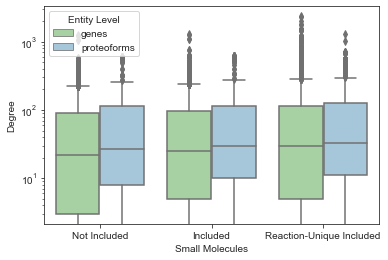

In [92]:
# The interactoms are 0: no_sm-genes, 1: no_sm-proteoforms, 2: with_sm-genes, 3: with_sm-proteoforms, 4: with_unique_sm-genes, 5: with_unique_sm-proteoforms
for i in [1, 3, 5]:
    degree_sequences[i] = [degree for proteoform_node, degree in interactomes[i].degree(proteoforms_with_annotations)]

degree_sequences = pd.Series(degree_sequences, index=index)

df_seq = pd.DataFrame({"Sequence": degree_sequences})
df_seq
df_seq.reset_index(inplace=True)

lst_col = 'Sequence'

df_seq = pd.DataFrame({
    col: np.repeat(df_seq[col].values, df_seq[lst_col].str.len())
    for col in df_seq.columns.drop(lst_col)}
).assign(**{lst_col: np.concatenate(df_seq[lst_col].values)})[df_seq.columns]

df_seq = df_seq.rename(columns={'Sequence': 'Degree'})
df_seq
ax = sns.boxplot(x="Small Molecules", y="Degree", hue="Entity Level",
                 data=df_seq, palette=[COLOR_GENES_FILL, COLOR_PROTEOFORMS_FILL])
ax.set_yscale('log')
ax.figure.savefig('figures/degree_interactomes_proteoforms_with_annotations.png')

## Count proteoforms with higher or lower degree than genes

In [93]:
def getChange(value):
    if value > 0: return "+"
    elif value == 0: return "="
    else: return "-"

df_degrees_genes_vs_all_proteoforms["Degree Difference"] = df_degrees_genes_vs_all_proteoforms["Proteoform Degree"] - df_degrees_genes_vs_all_proteoforms["Gene Degree"]
df_degrees_genes_vs_all_proteoforms["Change"] = df_degrees_genes_vs_all_proteoforms["Degree Difference"].apply(lambda d: getChange(d))
df_degrees_genes_vs_all_proteoforms

print(f"For all proteoforms: ")
df_cases = pd.DataFrame(df_degrees_genes_vs_all_proteoforms.groupby(['Change']).size(), columns=["Count"])

df_cases["Percentage"] = df_cases["Count"] / len(df_degrees_genes_vs_all_proteoforms) * 100
print(df_cases)

print(f"For proteoforms with annotations: ")
cases = df_degrees_genes_vs_all_proteoforms.loc[df_degrees_genes_vs_all_proteoforms["Annotations"] == True].groupby(['Change']).size()
df_cases = pd.DataFrame(cases, columns=["Count"])
df_cases["Percentage"] = df_cases["Count"] / len(df_degrees_genes_vs_all_proteoforms.loc[df_degrees_genes_vs_all_proteoforms["Annotations"] == True]) * 100
print(df_cases)

print(f"For proteoforms no annotations: ")
df_cases = pd.DataFrame(df_degrees_genes_vs_all_proteoforms.loc[df_degrees_genes_vs_all_proteoforms["Annotations"] == False].groupby(['Change']).size(), columns=["Count"])
df_cases["Percentage"] = df_cases["Count"] / len(df_degrees_genes_vs_all_proteoforms.loc[df_degrees_genes_vs_all_proteoforms["Annotations"] == False]) * 100
print(df_cases)

For all proteoforms: 
        Count  Percentage
Change                   
+        4979       34.95
-        2688       18.87
=        6579       46.18
For proteoforms with annotations: 
        Count  Percentage
Change                   
+        1227       35.74
-        1960       57.09
=         246        7.17
For proteoforms no annotations: 
        Count  Percentage
Change                   
+        3752       34.70
-         728        6.73
=        6333       58.57


## Examples of proteoforms that have higher degree than gene nodes

In [94]:
df_degrees_genes_vs_all_proteoforms.sort_values(by = "Degree Difference").tail(20)

,Proteoform,Proteoform Degree,Gene,Gene Degree,Annotations,Degree Difference,Change
2857,Q9P218;00039:null,538,COL20A1,58,True,480,+
2832,Q02388;,601,COL7A1,121,False,480,+
2803,P12110;00039:null,546,COL6A2,66,True,480,+
2807,P12109;00039:null,546,COL6A1,66,True,480,+
2810,P12111;00039:null,546,COL6A3,66,True,480,+
2812,A8TX70;00039:null,546,COL6A5,66,True,480,+
2814,A6NMZ7;00039:null,546,COL6A6,66,True,480,+
1737,Q99715;00039:null,539,COL12A1,59,True,480,+
2846,P12107;00039:null,546,COL11A1,66,True,480,+
2848,P02458;00039:null,546,COL2A1,66,True,480,+


## Example of how the degree of some proteoforms increases

In [102]:
gene = "COL7A1"
protein = "Q02388"

# Get pathways in which gene X participates
pathways = get_query_result(QUERY_GET_PATHWAYS_BY_PROTEIN.replace("identifier:\"\"", f"identifier:\"{protein}\""))
pathway = "R-HSA-1650814"
# Check plots at gene and proteoform level

graphs = create_pathway_interaction_networks(pathway, config.PATHWAY_GRAPHS_PATH)
graphs


{'no_sm': {'genes': <networkx.classes.graph.Graph at 0x14e42d4cdf0>,
  'proteoforms': <networkx.classes.graph.Graph at 0x14e42d4fc10>},
 'with_sm': {'genes': <networkx.classes.graph.Graph at 0x14e42d4fb50>,
  'proteoforms': <networkx.classes.graph.Graph at 0x14e42d4dab0>},
 'with_unique_sm': {'genes': <networkx.classes.graph.Graph at 0x14e42d4de70>,
  'proteoforms': <networkx.classes.graph.Graph at 0x14e42d4e290>}}

In [103]:
p = v.plot_pathway_all_levels(pathway, out_path=PATHWAY_GRAPHS_PATH, graphs=graphs,
                                coloring=v.Coloring.ENTITY_TYPE, outline_line_width=1,
                                node_size=12,
                                inner_plot_size=350,
                                highlight_articulations=True,
                                highlight_bridges=True,
                                toolbar_location=None)

IndexError: list index out of range

## Plot degree of all proteoforms compared to gene degree

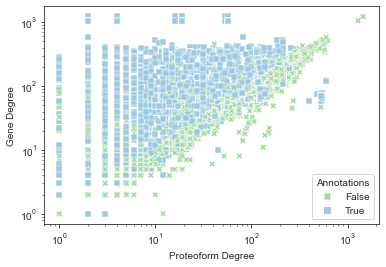

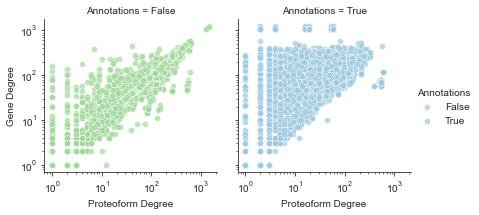

In [ ]:


markers = {True: "s", False: "X"}
sns.set_style("ticks")
plot = sns.scatterplot(data=df_degrees_genes_vs_all_proteoforms, x="Proteoform Degree", y="Gene Degree", hue="Annotations", style="Annotations", markers=markers, palette=[COLOR_GENES_FILL, COLOR_PROTEOFORMS_FILL])
plot.set(xscale="log", yscale="log")

plot = sns.FacetGrid(df_degrees_genes_vs_all_proteoforms, col="Annotations", hue="Annotations", palette=[COLOR_GENES_FILL, COLOR_PROTEOFORMS_FILL])
plot.map(sns.scatterplot, "Proteoform Degree", "Gene Degree", alpha=.7, markers=markers)
plot.add_legend()
for ax in plot.axes_dict.values():
    ax.axline((0, 0), slope=.2, c=".2", ls="--", zorder=0)
plot.set(xscale="log", yscale="log")


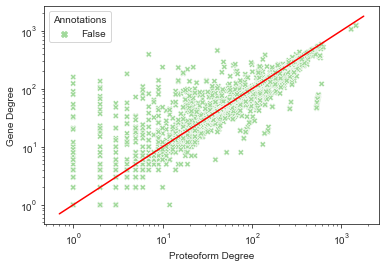

In [ ]:
# Plot proteoform vs gene degree for non annotated proteoforms

df = df_degrees_genes_vs_all_proteoforms.loc[df_degrees_genes_vs_all_proteoforms["Annotations"] == False]

plot = sns.scatterplot(data=df, x="Proteoform Degree", y="Gene Degree", hue="Annotations", style="Annotations", markers=markers, palette=[COLOR_GENES_FILL])
plot.set(xscale="log", yscale="log")

# Draw a line of x=y 
x0, x1 = plot.get_xlim()
y0, y1 = plot.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
plot.plot(lims, lims, '-r')

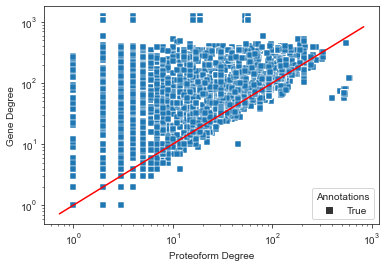

In [ ]:
# Plot proteoform vs gene degree for annotated proteoforms

df = df_degrees_genes_vs_all_proteoforms.loc[df_degrees_genes_vs_all_proteoforms["Annotations"] == True]
plot = sns.scatterplot(data=df_degrees_genes_vs_proteoforms_with_annotations, x="Proteoform Degree", y="Gene Degree", style="Annotations", markers=markers, palette=[COLOR_PROTEOFORMS_FILL])
plot.set(xscale="log", yscale="log")

# Draw a line of x=y 
x0, x1 = plot.get_xlim()
y0, y1 = plot.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
plot.plot(lims, lims, '-r')

## Plot degree of small molecules

In [ ]:
# TODO: Plot degree of small molecules

# Degree by Pathways

In [ ]:
columns = [
    'Pathway',
    'Small Molecules',
    'Increase Nodes Genes-Proteins',
    'Increase Interactions Genes-Proteins',
    'Increase Nodes Proteins-Proteoforms',
    'Increase Interactions Proteins-Proteoforms'
]


def get_pathway_tuples(pathway, graphs):
    increase_nodes_genes_proteins = get_increase_percentage(graphs[genes].number_of_nodes(),
                                                            graphs[proteins].number_of_nodes())
    increase_links_genes_proteins = get_increase_percentage(graphs[genes].number_of_edges(),
                                                            graphs[proteins].number_of_edges())
    increase_nodes_proteins_proteoforms = get_increase_percentage(graphs[proteins].number_of_nodes(),
                                                                  graphs[proteoforms].number_of_nodes())
    increase_links_proteins_proteoforms = get_increase_percentage(graphs[proteoforms].number_of_edges(),
                                                                  graphs[proteoforms].number_of_edges())

    return (
        pathway,
        graphs[genes].graph["method"],
        increase_nodes_genes_proteins,
        increase_links_genes_proteins,
        increase_nodes_proteins_proteoforms,
        increase_links_proteins_proteoforms
    )


data_pathways = []
# pathways = get_pathways()["stId"]
pathways = get_pathways_with_multiple_proteoforms(INTERACTOMES_PATH, PATHWAY_GRAPHS_PATH)
for pathway in pathways:
    for method in METHODS:
        pathway_graphs = {}
        for level in LEVELS:
            filename = get_json_filename(level, method, PATHWAY_GRAPHS_PATH, pathway)
            if not os.path.exists(filename):
                create_pathway_interaction_network(pathway, level, method, PATHWAY_GRAPHS_PATH)
            G = read_graph(filename)
            pathway_graphs[level] = G
        if pathway_graphs[genes].number_of_nodes() > 0\
                and pathway_graphs[genes].number_of_edges() > 0\
                and pathway_graphs[genes].number_of_nodes() < 20:
            data_pathways.append(get_pathway_tuples(pathway, pathway_graphs))

df_pathways = pd.DataFrame.from_records(data_pathways, columns=columns)
df_pathways

    * Creating network networks\pathways\R-HSA-9613829_genes_no_sm.json


OSError: Cannot save file into a non-existent directory: 'networks\pathways\complexes'

In [ ]:
from bokeh.io import show
from visualization.visualize_single_network import Coloring, plot_pathway_all_levels
from lib.networks import create_pathway_interaction_networks

# Example nodes genes-proteins
df_pathways.sort_values(by=['Increase Nodes Genes-Proteins'], ascending=False, inplace=True)
examples = df_pathways.head(20)["Pathway"].unique()
print(examples)

for example in examples:
    graphs = create_pathway_interaction_networks(example, "resources/pathway_networks/")
    p = plot_pathway_all_levels(example, out_path="resources/pathway_networks/", graphs=graphs,
                                coloring=Coloring.ENTITY_TYPE, outline_line_width=1,
                                node_size = 12,
                                inner_plot_size=350,
                                highlight_articulations=True,
                                highlight_bridges=True,
                                toolbar_location='below')
    show(p)
df_pathways.head(20)

['R-HSA-1236977' 'R-HSA-947581' 'R-HSA-392851' 'R-HSA-8934903'
 'R-HSA-9637628' 'R-HSA-9673768' 'R-HSA-9673770' 'R-HSA-9673766'
 'R-HSA-9673767' 'R-HSA-9636569' 'R-HSA-1839120']
-- Creating interaction networks for pathway R-HSA-1236977
Generated figure: resources/pathway_networks/R-HSA-1236977_ENTITY_TYPE_network.html
-- Creating interaction networks for pathway R-HSA-947581
Generated figure: resources/pathway_networks/R-HSA-947581_ENTITY_TYPE_network.html
-- Creating interaction networks for pathway R-HSA-392851
Generated figure: resources/pathway_networks/R-HSA-392851_ENTITY_TYPE_network.html
-- Creating interaction networks for pathway R-HSA-8934903
Generated figure: resources/pathway_networks/R-HSA-8934903_ENTITY_TYPE_network.html
-- Creating interaction networks for pathway R-HSA-9637628
Generated figure: resources/pathway_networks/R-HSA-9637628_ENTITY_TYPE_network.html
-- Creating interaction networks for pathway R-HSA-9673768
Generated figure: resources/pathway_networks/R-HSA-9

,Pathway,Small Molecules,Increase Nodes Genes-Proteins,Increase Interactions Genes-Proteins,Increase Nodes Proteins-Proteoforms,Increase Interactions Proteins-Proteoforms
726,R-HSA-1236977,no_sm,84.81,98.74,0.00,0.00
727,R-HSA-1236977,with_sm,80.72,97.88,0.00,0.00
1266,R-HSA-947581,no_sm,14.29,33.33,30.00,0.00
1472,R-HSA-392851,no_sm,5.00,10.00,0.00,0.00
0,R-HSA-8934903,no_sm,0.00,0.00,21.43,0.00
1115,R-HSA-9637628,with_unique_sm,0.00,0.00,0.00,0.00
1125,R-HSA-9673768,with_unique_sm,0.00,0.00,46.15,0.00
1124,R-HSA-9673768,with_sm,0.00,0.00,46.15,0.00
1123,R-HSA-9673768,no_sm,0.00,0.00,54.55,0.00
1122,R-HSA-9673770,with_sm,0.00,0.00,10.00,0.00


In [ ]:
df_pathways.sort_values(by=['Increase Nodes Proteins-Proteoforms'], ascending=False, inplace=True)
examples = df_pathways.head(10)["Pathway"].unique()
print(examples)
df_pathways[["Pathway", "Increase Nodes Proteins-Proteoforms", "Increase Interactions Proteins-Proteoforms"]].head(20)

['R-HSA-69200' 'R-HSA-3000480' 'R-HSA-444257' 'R-HSA-2214320'
 'R-HSA-1912399' 'R-HSA-9673768']


,Pathway,Increase Nodes Proteins-Proteoforms,Increase Interactions Proteins-Proteoforms
52,R-HSA-69200,77.78,0.00
54,R-HSA-69200,70.00,0.00
53,R-HSA-69200,70.00,0.00
828,R-HSA-3000480,64.81,0.00
591,R-HSA-444257,63.16,0.00
1446,R-HSA-2214320,61.11,0.00
1447,R-HSA-2214320,61.11,0.00
1448,R-HSA-2214320,61.11,0.00
789,R-HSA-1912399,57.14,0.00
1123,R-HSA-9673768,54.55,0.00


In [ ]:
df_pathways.sort_values(by=['Increase Interactions Proteins-Proteoforms'], ascending=False, inplace=True)
df_pathways[["Pathway", "Increase Nodes Proteins-Proteoforms", "Increase Interactions Proteins-Proteoforms"]].head(12)

,Pathway,Increase Nodes Proteins-Proteoforms,Increase Interactions Proteins-Proteoforms
52,R-HSA-69200,77.78,0.00
680,R-HSA-71032,0.00,0.00
992,R-HSA-162592,0.00,0.00
991,R-HSA-162594,0.00,0.00
970,R-HSA-9694635,0.00,0.00
1025,R-HSA-8869496,0.00,0.00
957,R-HSA-9683686,0.00,0.00
958,R-HSA-9683686,0.00,0.00
1034,R-HSA-8952158,0.00,0.00
1033,R-HSA-8949275,0.00,0.00


In [ ]:
# Table with degrees.
columns = [
    "Small Molecules",
    "Entity Level",
    "Q_1 Acc. Ent.",
    "Q_2 Acc. Ent.",
    "Q_3 Acc. Ent.",
    "Q_4 Acc. Ent.",
    "Q_1 S. Mol.",
    "Q_2 S. Mol.",
    "Q_3 S. Mol.",
    "Q_4 S. Mol.",
]

def get_tuples(G):

    acc_ents = list(G.nodes)
    sm_ents = []
    if G.graph['num_small_molecules'] > 0:
        acc_ents = [n for n in G.nodes if not G.nodes[n]['type'].startswith("Simple")]
        sm_ents = [n for n in G.nodes if G.nodes[n]['type'].startswith("Simple")]

    deg_seq_acc_ents = [d for n, d in list(G.degree(acc_ents))]

    values_ae = np.quantile(deg_seq_acc_ents, [0,0.25,0.5,0.75,1])
    values_sm = [0] * 5
    if len(sm_ents) > 0:
        deg_seq_sm_ents = [d for n, d in list(G.degree(sm_ents))]
        values_sm = np.quantile(deg_seq_sm_ents, [0,0.25,0.5,0.75,1])

    return (G.graph["method"], G.graph["level"], *(values_ae)[1:], *(values_sm[1:]))

In [ ]:
values = [get_tuples(I) for I in interactomes]
df_deg_interactomes = pd.DataFrame(values, columns=columns, index=index)
df_deg_interactomes.drop(["Small Molecules","Entity Level"], axis=1)
dfi.export(df_deg_interactomes, "figures/df_degree_interactomes.png")
df_deg_interactomes

Small Molecules Entity Level  \
Small Molecules          Entity Level                                
Not Included             genes                  no_sm        genes   
                         proteoforms            no_sm  proteoforms   
Included                 genes                with_sm        genes   
                         proteoforms          with_sm  proteoforms   
Reaction-Unique Included genes         with_unique_sm        genes   
                         proteoforms   with_unique_sm  proteoforms   

                                       Q_1 Acc. Ent.  Q_2 Acc. Ent.  \
Small Molecules          Entity Level                                 
Not Included             genes                  3.00          22.00   
                         proteoforms            4.00          23.00   
Included                 genes                  5.00          25.00   
                         proteoforms            6.00          26.00   
Reaction-Unique Included genes                  5.00          30.00   
                         proteoforms            6.00          30.00   

                                       Q_3 Acc. Ent.  Q_4 Acc. Ent.  \
Small Molecules          Entity Level                                 
Not Included             genes                 91.00       1,243.00   
                         proteoforms          109.00       1,474.00   
Included                 genes                 98.00       1,290.00   
                         proteoforms          116.00       1,520.00   
Reaction-Unique Included genes                115.00       2,361.00   
                         proteoforms          128.00       2,376.00   

                                       Q_1 S. Mol.  Q_2 S. Mol.  Q_3 S. Mol.  \
Small Molecules          Entity Level                                          
Not Included             genes                0.00         0.00         0.00   
                         proteoforms          0.00         0.00         0.00   
Included                 genes                4.00         7.00        20.00   
                         proteoforms          4.00         7.00        20.00   
Reaction-Unique Included genes                2.00         4.00        10.00   
                         proteoforms          2.00         4.00        10.00   

                                       Q_4 S. Mol.  
Small Molecules          Entity Level               
Not Included             genes                0.00  
                         proteoforms          0.00  
Included                 genes            3,473.00  
                         proteoforms      4,141.00  
Reaction-Unique Included genes              304.00  
                         proteoforms        304.00

In [ ]:
for method in config.SMALL_MOLECULES:
    print(f"Small Molecules: {method}")
    avg_genes = df_deg_interactomes.loc[method,'genes']["Avg. Degree Accessioned Entities"]
    avg_proteoforms = df_deg_interactomes.loc[method,'proteoforms']["Avg. Degree Accessioned Entities"]
    inc_genes_proteoforms = get_increase_percentage(avg_genes, avg_proteins)
    inc_proteins_proteoforms = get_increase_percentage(avg_proteins, avg_proteoforms)
    print(f"There is an increase of degree: {inc_genes_proteins}% from genes to proteins")
    print(f"There is an increase of degree: {inc_proteins_proteoforms}% from proteins to proteoforms")


Small Molecules: Not Included


KeyError: 'Avg. Degree Accessioned Entities'

In [ ]:
combinations = get_combinations_with_pathways(3)

columns = [
    "Small Molecules",
    "Entity Level",
    "Pathway",
    "Min. Degree Accessioned Entities",
    "Avg. Degree Accessioned Entities",
    "Max. Degree Accessioned Entities",
    "Min. Degree Small Molecules",
    "Avg. Degree Small Molecules",
    "Max. Degree Small Molecules"
]

out_path = "resources/pathway_networks/"

def get_tuples(combination):
    G = create_pathway_interaction_network(
        method=combination[0], level=combination[1], pathway=combination[2], out_path=out_path
    )

    acc_ents = list(G.nodes)
    sm_ents = []
    if G.graph['num_small_molecules'] > 0:
        acc_ents = [n for n in G.nodes if not G.nodes[n]['type'].startswith("Simple")]
        sm_ents = [n for n in G.nodes if G.nodes[n]['type'].startswith("Simple")]

    deg_seq_acc_ents = [d for n, d in list(G.degree(acc_ents))]
    min_deg_sm_ents = 0
    avg_deg_sm_ents = 0
    max_deg_sm_ents = 0
    if len(sm_ents) > 0:
        deg_seq_sm_ents = [d for n, d in list(G.degree(sm_ents))]
        min_deg_sm_ents = min(deg_seq_sm_ents)
        avg_deg_sm_ents = mean(deg_seq_sm_ents)
        max_deg_sm_ents = max(deg_seq_sm_ents)

    return (
        combination[0], combination[1], combination[2],
        min(deg_seq_acc_ents), mean(deg_seq_acc_ents), max(deg_seq_acc_ents),
        min_deg_sm_ents, avg_deg_sm_ents, max_deg_sm_ents
    )

In [ ]:
df_deg_pathways = pd.DataFrame([get_tuples(combination) for combination in combinations], columns=columns)
df_deg_pathways

,Small Molecules,Entity Level,Pathway,Min. Degree Accessioned Entities,Avg. Degree Accessioned Entities,Max. Degree Accessioned Entities,Min. Degree Small Molecules,Avg. Degree Small Molecules,Max. Degree Small Molecules
0,no_sm,genes,R-HSA-9613829,1,17.90,19,0,0.00,0
1,no_sm,genes,R-HSA-1632852,0,16.82,37,0,0.00,0
2,no_sm,genes,R-HSA-5205685,4,8.09,14,0,0.00,0
3,no_sm,proteins,R-HSA-9613829,1,17.90,19,0,0.00,0
4,no_sm,proteins,R-HSA-1632852,0,16.82,37,0,0.00,0
5,no_sm,proteins,R-HSA-5205685,4,8.09,14,0,0.00,0
6,no_sm,proteoforms,R-HSA-9613829,1,17.18,19,0,0.00,0
7,no_sm,proteoforms,R-HSA-1632852,0,16.96,40,0,0.00,0
8,no_sm,proteoforms,R-HSA-5205685,4,8.08,18,0,0.00,0
9,with_sm,genes,R-HSA-9613829,2,17.95,19,1,1.00,1


In [ ]:
df_deg_pathways_agg = df_deg_pathways.groupby(['Small Molecules', 'Entity Level']).agg(
    {
        "Min. Degree Accessioned Entities": ['mean'],
        "Avg. Degree Accessioned Entities": ['mean'],
        "Max. Degree Accessioned Entities": ['mean'],
        "Min. Degree Small Molecules": ['mean'],
        "Avg. Degree Small Molecules": ['mean'],
        "Max. Degree Small Molecules": ['mean']
    })
df_deg_pathways_agg.columns = [
    "Min. Degree Accessioned Entities",
    "Avg. Degree Accessioned Entities",
    "Max. Degree Accessioned Entities",
    "Min. Degree Small Molecules",
    "Avg. Degree Small Molecules",
    "Max. Degree Small Molecules"
]
df_pathways_grouped = df_deg_pathways_agg.set_index(get_multiindex())
df_pathways_grouped

Min. Degree Accessioned Entities  \
Small Molecules          Entity Level                                     
Not Included             genes                                     1.67   
                         proteins                                  1.67   
                         proteoforms                               1.67   
Included                 genes                                     2.33   
                         proteins                                  2.33   
                         proteoforms                               2.33   
Reaction-Unique Included genes                                     3.33   
                         proteins                                  3.33   
                         proteoforms                               2.33   

                                       Avg. Degree Accessioned Entities  \
Small Molecules          Entity Level                                     
Not Included             genes                                    14.27   
                         proteins                                 14.27   
                         proteoforms                              14.07   
Included                 genes                                    14.89   
                         proteins                                 14.89   
                         proteoforms                              14.64   
Reaction-Unique Included genes                                    16.73   
                         proteins                                 16.73   
                         proteoforms                              16.16   

                                       Max. Degree Accessioned Entities  \
Small Molecules          Entity Level                                     
Not Included             genes                                    23.33   
                         proteins                                 23.33   
                         proteoforms                              25.67   
Included                 genes                                    24.00   
                         proteins                                 24.00   
                         proteoforms                              27.00   
Reaction-Unique Included genes                                    34.00   
                         proteins                                 34.00   
                         proteoforms                              37.67   

                                       Min. Degree Small Molecules  \
Small Molecules          Entity Level                                
Not Included             genes                                0.00   
                         proteins                             0.00   
                         proteoforms                          0.00   
Included                 genes                                1.67   
                         proteins                             1.67   
                         proteoforms                          1.67   
Reaction-Unique Included genes                                0.67   
                         proteins                             0.67   
                         proteoforms                          0.67   

                                       Avg. Degree Small Molecules  \
Small Molecules          Entity Level                                
Not Included             genes                                0.00   
                         proteins                             0.00   
                         proteoforms                          0.00   
Included                 genes                                8.07   
                         proteins                             8.07   
                         proteoforms                          8.80   
Reaction-Unique Included genes                                4.70   
                         proteins                             4.70   
                         proteoforms                          4.75   

                   

Text(0.5, 1.0, 'Distribution of Avg. Degree of Accessioned Entities in all Pathways')

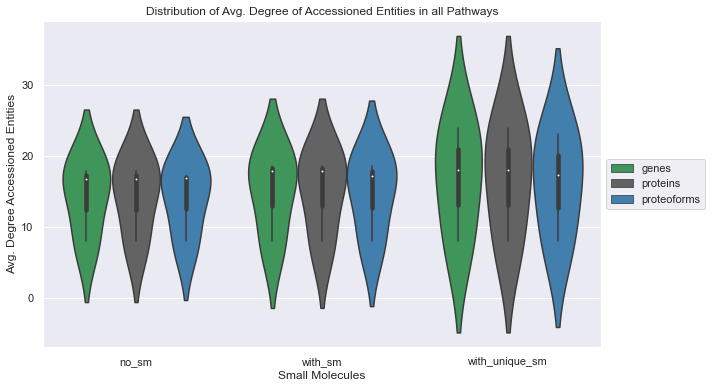

In [ ]:
import matplotlib.pyplot as plt

sns.set(rc = {"figure.facecolor": "white"})

fig, ax = plt.subplots(1, 1, figsize=(5, 6))
fig.set_size_inches(10, 6)
f = sns.violinplot(x="Small Molecules", y="Avg. Degree Accessioned Entities", hue="Entity Level",
                   data=df_deg_pathways, palette=config.COLORS_BORDER)
#ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$")) # Convert ticks to powers of 10
f.legend(loc='center left', bbox_to_anchor=(1, 0.5))
f.set_title("Distribution of Avg. Degree of Accessioned Entities in all Pathways")

Text(0.5, 1.0, 'Distribution of Avg. Degree of Small Molecules in all Pathways')

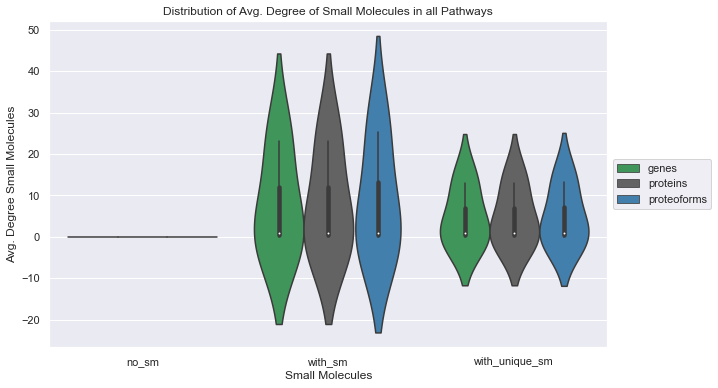

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 6))
fig.set_size_inches(10, 6)
f = sns.violinplot(x="Small Molecules", y="Avg. Degree Small Molecules", hue="Entity Level",
                   data=df_deg_pathways, palette=config.COLORS_BORDER)
#ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$")) # Convert ticks to powers of 10
f.legend(loc='center left', bbox_to_anchor=(1, 0.5))
f.set_title("Distribution of Avg. Degree of Small Molecules in all Pathways")

In [ ]:
df_deg_pathways[
    (df_deg_pathways["Small Molecules"] == 'with_unique_sm') & (df_deg_pathways["Entity Level"] == 'proteoforms')]

,Small Molecules,Entity Level,Pathway,Min. Degree Accessioned Entities,Avg. Degree Accessioned Entities,Max. Degree Accessioned Entities,Min. Degree Small Molecules,Avg. Degree Small Molecules,Max. Degree Small Molecules
24,with_unique_sm,proteoforms,R-HSA-9613829,2,17.36,19,1,1.00,1
25,with_unique_sm,proteoforms,R-HSA-1632852,1,23.04,76,1,13.25,30
26,with_unique_sm,proteoforms,R-HSA-5205685,4,8.08,18,0,0.00,0


In [ ]:
df_pathways_grouped.reset_index(inplace=True)
df_pathways_grouped

,Small Molecules,Entity Level,Min. Degree Accessioned Entities,Avg. Degree Accessioned Entities,Max. Degree Accessioned Entities,Min. Degree Small Molecules,Avg. Degree Small Molecules,Max. Degree Small Molecules
0,Not Included,genes,1.67,14.27,23.33,0.00,0.00,0.00
1,Not Included,proteins,1.67,14.27,23.33,0.00,0.00,0.00
2,Not Included,proteoforms,1.67,14.07,25.67,0.00,0.00,0.00
3,Included,genes,2.33,14.89,24.00,1.67,8.07,12.67
4,Included,proteins,2.33,14.89,24.00,1.67,8.07,12.67
5,Included,proteoforms,2.33,14.64,27.00,1.67,8.80,14.67
6,Reaction-Unique Included,genes,3.33,16.73,34.00,0.67,4.70,10.00
7,Reaction-Unique Included,proteins,3.33,16.73,34.00,0.67,4.70,10.00
8,Reaction-Unique Included,proteoforms,2.33,16.16,37.67,0.67,4.75,10.33


In [ ]:
df_interactomes_temp = df_deg_interactomes[["Avg. Degree Accessioned Entities",
    "Avg. Degree Small Molecules"]]
df_interactomes_temp.reset_index(inplace=True)
df_interactomes_temp

,Small Molecules,Entity Level,Avg. Degree Accessioned Entities,Avg. Degree Small Molecules
0,Not Included,genes,82.63,0.00
1,Not Included,proteins,83.58,0.00
2,Not Included,proteoforms,94.73,0.00
3,Included,genes,88.31,45.48
4,Included,proteins,89.26,45.79
5,Included,proteoforms,99.53,48.69
6,Reaction-Unique Included,genes,112.64,15.77
7,Reaction-Unique Included,proteins,113.77,15.94
8,Reaction-Unique Included,proteoforms,118.77,16.29


In [ ]:
df_degrees = pd.concat([df_interactomes_temp, df_pathways_grouped[["Avg. Degree Accessioned Entities",
    "Avg. Degree Small Molecules"]]], axis=1)
df_degrees.set_index(index, inplace=True)
df_degrees.drop(df_degrees.columns[[0,1]],axis=1,inplace=True)
df_degrees

Avg. Degree Accessioned Entities  \
Small Molecules          Entity Level                                     
Not Included             genes                                    82.63   
                         proteins                                 83.58   
                         proteoforms                              94.73   
Included                 genes                                    88.31   
                         proteins                                 89.26   
                         proteoforms                              99.53   
Reaction-Unique Included genes                                   112.64   
                         proteins                                113.77   
                         proteoforms                             118.77   

                                       Avg. Degree Small Molecules  \
Small Molecules          Entity Level                                
Not Included             genes                                0.00   
                         proteins                             0.00   
                         proteoforms                          0.00   
Included                 genes                               45.48   
                         proteins                            45.79   
                         proteoforms                         48.69   
Reaction-Unique Included genes                               15.77   
                         proteins                            15.94   
                         proteoforms                         16.29   

                                       Avg. Degree Accessioned Entities  \
Small Molecules          Entity Level                                     
Not Included             genes                                    14.27   
                         proteins                                 14.27   
                         proteoforms                              14.07   
Included                 genes                                    14.89   
                         proteins                                 14.89   
                         proteoforms                              14.64   
Reaction-Unique Included genes                                    16.73   
                         proteins                                 16.73   
                         proteoforms                              16.16   

                                       Avg. Degree Small Molecules  
Small Molecules          Entity Level                               
Not Included             genes                                0.00  
                         proteins                             0.00  
                         proteoforms                          0.00  
Included                 genes                                8.07  
                         proteins                             8.07  
                         proteoforms                          8.80  
Reaction-Unique Included genes                                4.70  
                         proteins                             4.70  
                         proteoforms                          4.75